In [1]:
import os
import pandas as pd
import re
import json

In [2]:
# Contry Codes to JSON
countries_dict = {
    "SP": 0,  # Spain
    "UK": 1,  # United Kingdom
    "DE": 2,  # Germany
    "DK": 3,  # Denmark
    "HU": 5,  # Hungary
    "SE": 4,  # Sweden
    "IT": 6,  # Italy
    "PO": 7,  # Poland
    "NL": 8   # Netherlands
}


In [200]:
# Contry Codes to JSON
energy_types_dict = {
    "B01": "Biomass",
    "B02": "Fossil Brown coal/Lignite",
    "B03": "Fossil Coal-derived gas",
    "B04": "Fossil Gas",
    "B05": "Fossil Hard coal",
    "B06": "Fossil Oil",
    "B07": "Fossil Oil shale",
    "B08": "Fossil Peat",
    "B09": "Geothermal",
    "B10": "Hydro Pumped Storage",
    "B11": "Hydro Run-of-river and poundage",
    "B12": "Hydro Water Reservoir",
    "B13": "Marine",
    "B14": "Nuclear",
    "B15": "Other renewable",
    "B16": "Solar",
    "B17": "Waste",
    "B18": "Wind Offshore",
    "B19": "Wind Onshore",
    "B20": "Other",
    "B21": "AC Link",
    "B22": "DC Link",
    "B23": "Substation",
    "B24": "Transformer"
}


In [215]:
import pandas as pd

def impute_missing_values_mean(este):

    # Itera sobre los valores
    for i in range(len(este)):
        current_value = este.at[este.index[i], 'quantity']

        # Si el valor es None, busca el valor anterior y posterior
        #if current_value.isna():
        if current_value is None:

            # Encuentra el valor anterior
            backward_values = este['quantity'].iloc[:i].dropna()
            backward_value = backward_values.max() if not backward_values.empty else None

            # Encuentra el valor posterior
            forward_values = este['quantity'].iloc[i:].dropna()
            forward_value = forward_values.min() if not forward_values.empty else None

            # Calcula la media de los valores existentes
            if backward_value is not None and forward_value is not None:
                imputed_value = (backward_value + forward_value) / 2
            elif backward_value is not None:
                imputed_value = backward_value
            elif forward_value is not None:
                imputed_value = forward_value
            else:
                imputed_value = None

            # Imputa el valor central con la media de los valores existentes
            este.at[este.index[i], 'quantity'] = imputed_value

    return este


In [216]:
# Directory where raw CSV files are stored
directory = "../jupyter_notebook/data_samples"
# Parsing date strings, ignoring any timezone information and converting them to datetime objects
date_parser = lambda x: pd.to_datetime(x[:22])
# List to hold all the dataframes
dataframes = []

# Iterate through all files in the directory
for filename in os.listdir(directory):

    if re.match(r'gen_[A-Z]{2}_[A-Z0-9]+\.csv', filename):

        # Read the CSV file
        df = pd.read_csv(os.path.join(directory, filename), converters={'EndTime': date_parser}).set_index('EndTime')
                        
        numeric_cols = df.select_dtypes(include=['number'])
        categorical_cols = df.select_dtypes(exclude=['number', 'datetime64[ns]', 'bool'])
        
        # Resample the numeric columns and sum
        resampled_df_num = numeric_cols.resample('H').sum()

        # Resample the categorical columns.
        # Here, we take the first value. Adjust the method if needed (e.g., 'last', or a custom function to get the mode)
        resampled_df_cat= categorical_cols.resample('H').last()

        # Combine the resampled DataFrames back together
        resampled_df = pd.concat([resampled_df_num, resampled_df_cat], axis=1)
       
        # Extract country and energy type from filename
        _, country, energy_type = filename.split('_')
        energy_type = energy_type.replace('.csv', '') # Remove the file extension

        # Add country and energy type as new columns
        resampled_df['CountryCode'] = country
        resampled_df['EnergyTypeCode'] = energy_type
                
        # Append the dataframe to the list
        dataframes.append(resampled_df)

# Concatenate all dataframes (if needed)
final_df = pd.concat(dataframes)

In [649]:
final_df['UnitName'].value_counts(dropna=False)

UnitName
MAW    377233
Name: count, dtype: int64

In [217]:
este[este['StartTime'].isna()]

quantity StartTime AreaID UnitName PsrType  \
EndTime                                                                 
2022-01-28 00:00:00+00:00    1068.5      None   None     None    None   
2022-01-28 01:00:00+00:00    1068.5      None   None     None    None   
2022-01-28 02:00:00+00:00    1068.5      None   None     None    None   
2022-01-28 03:00:00+00:00    1068.5      None   None     None    None   
2022-01-28 04:00:00+00:00    1068.5      None   None     None    None   
...                             ...       ...    ...      ...     ...   
2022-12-28 04:00:00+00:00    2090.0      None   None     None    None   
2022-12-30 15:00:00+00:00    2090.0      None   None     None    None   
2022-12-30 17:00:00+00:00    2090.0      None   None     None    None   
2022-12-30 19:00:00+00:00    2090.0      None   None     None    None   
2022-12-31 09:00:00+00:00    2130.5      None   None     None    None   

                          CountryCode EnergyTypeCode  
EndTime                                               
2022-01-28 00:00:00+00:00          UK            B19  
2022-01-28 01:00:00+00:00          UK            B19  
2022-01-28 02:00:00+00:00          UK            B19  
2022-01-28 03:00:00+00:00          UK            B19  
2022-01-28 04:00:00+00:00          UK            B19  
...                               ...            ...  
2022-12-28 04:00:00+00:00          UK            B19  
2022-12-30 15:00:00+00:00          UK            B19  
2022-12-30 17:00:00+00:00          UK            B19  
2022-12-30 19:00:00+00:00          UK            B19  
2022-12-31 09:00:00+00:00          UK            B19  

[4975 rows x 7 columns]

In [ ]:
M=final_df[(final_df['CountryCode']=='UK')&(final_df['EnergyTypeCode']=='B19')]



In [ ]:
M.isna().sum()

In [183]:
A=impute_missing_values_mean(M)


In [184]:
A.isna().sum()

StartTime    0
AreaID       0
UnitName     0
PsrType      0
quantity     0
dtype: int64

In [185]:
final_df[final_df['StartTime'].isna()]

quantity StartTime AreaID UnitName PsrType  \
EndTime                                                                 
2022-02-10 08:00:00+00:00       0.0      None   None     None    None   
2022-07-05 07:00:00+00:00       0.0      None   None     None    None   
2022-03-27 21:00:00+00:00       0.0      None   None     None    None   
2022-01-28 00:00:00+00:00       0.0      None   None     None    None   
2022-01-28 01:00:00+00:00       0.0      None   None     None    None   
...                             ...       ...    ...      ...     ...   
2022-12-30 17:00:00+00:00       0.0      None   None     None    None   
2022-12-30 19:00:00+00:00       0.0      None   None     None    None   
2022-12-31 09:00:00+00:00       0.0      None   None     None    None   
2022-03-27 21:00:00+00:00       0.0      None   None     None    None   
2022-03-27 21:00:00+00:00       0.0      None   None     None    None   

                          CountryCode EnergyTypeCode  
EndTime                                               
2022-02-10 08:00:00+00:00          DK            B01  
2022-07-05 07:00:00+00:00          DK            B01  
2022-03-27 21:00:00+00:00          SE            B16  
2022-01-28 00:00:00+00:00          UK            B19  
2022-01-28 01:00:00+00:00          UK            B19  
...                               ...            ...  
2022-12-30 17:00:00+00:00          UK            B06  
2022-12-30 19:00:00+00:00          UK            B06  
2022-12-31 09:00:00+00:00          UK            B06  
2022-03-27 21:00:00+00:00          SE            B20  
2022-03-27 21:00:00+00:00          SE            B19  

[28890 rows x 7 columns]

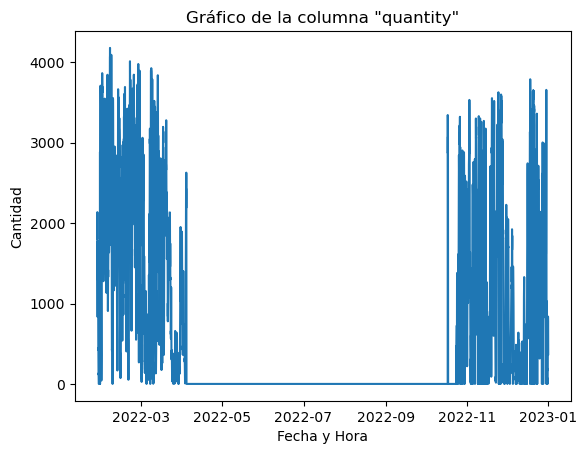

In [186]:
import matplotlib.pyplot as plt

# Suponiendo que ya tienes el DataFrame df con la columna 'quantity'

# Graficar la columna 'quantity'
plt.plot(M.index, M['quantity'])

# Añadir etiquetas y título
plt.xlabel('Fecha y Hora')
plt.ylabel('Cantidad')
plt.title('Gráfico de la columna "quantity"')

# Mostrar la leyenda si es necesario
# plt.legend(['quantity'])

# Mostrar el gráfico
plt.show()

In [141]:
import pandas as pd

# Supongamos que 'este' es tu DataFrame
# este = ...


# Itera sobre los valores
for i in range(len(este)):
    current_value = este.at[este.index[i], 'quantity']

    # Si el valor es None, busca el valor anterior y posterior
    if pd.isna(current_value):
        # Encuentra el valor anterior
        backward_values = este['quantity'].iloc[:i].dropna()
        backward_value = backward_values.max() if not backward_values.empty else None

        # Encuentra el valor posterior
        forward_values = este['quantity'].iloc[i:].dropna()
        forward_value = forward_values.min() if not forward_values.empty else None

        # Calcula la media de los valores existentes
        if backward_value is not None and forward_value is not None:
            imputed_value = (backward_value + forward_value) / 2
        elif backward_value is not None:
            imputed_value = backward_value
        elif forward_value is not None:
            imputed_value = forward_value
        else:
            imputed_value = None

        # Imputa el valor central con la media de los valores existentes
        este.at[este.index[i], 'quantity'] = imputed_value


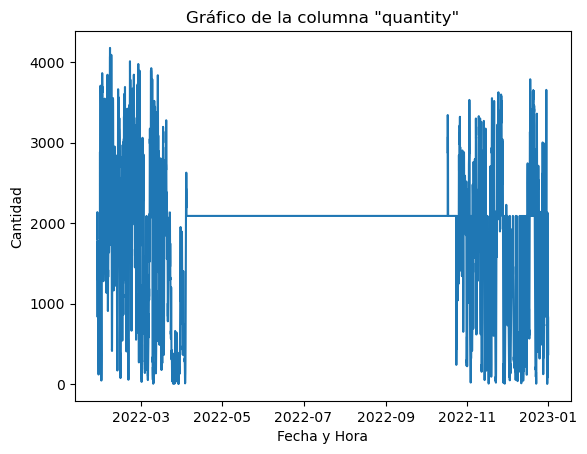

In [145]:
import matplotlib.pyplot as plt

# Suponiendo que ya tienes el DataFrame df con la columna 'quantity'

# Graficar la columna 'quantity'
plt.plot(este.index, este['quantity'])

# Añadir etiquetas y título
plt.xlabel('Fecha y Hora')
plt.ylabel('Cantidad')
plt.title('Gráfico de la columna "quantity"')

# Mostrar la leyenda si es necesario
# plt.legend(['quantity'])

# Mostrar el gráfico
plt.show()


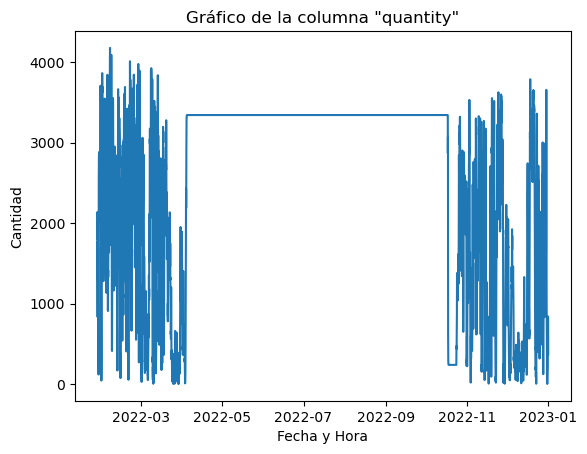

In [60]:
import matplotlib.pyplot as plt

# Suponiendo que ya tienes el DataFrame df con la columna 'quantity'

# Graficar la columna 'quantity'
plt.plot(df.index, df['quantity'])

# Añadir etiquetas y título
plt.xlabel('Fecha y Hora')
plt.ylabel('Cantidad')
plt.title('Gráfico de la columna "quantity"')

# Mostrar la leyenda si es necesario
# plt.legend(['quantity'])

# Mostrar el gráfico
plt.show()


In [18]:
# Map the energy type codes to full names
final_df['EnergyTypeName'] = final_df['EnergyTypeCode'].map(energy_types_dict)

In [19]:
#Filter by R.Energy
energy_type_codes_to_filter = ['B01', 'B09', 'B10', 'B11', 'B12', 'B13', 'B15','B16', 'B18', 'B19']

filtered_df = final_df[final_df['EnergyTypeCode'].isin(energy_type_codes_to_filter)]

In [28]:
filtered_df.loc[filtered_df['StartTime'].isna(),'quantity']=None

In [30]:
filtered_df.loc[filtered_df['StartTime'].isna()]

quantity StartTime AreaID UnitName PsrType  \
EndTime                                                                 
2022-02-10 08:00:00+00:00       NaN      None   None     None    None   
2022-07-05 07:00:00+00:00       NaN      None   None     None    None   
2022-01-28 00:00:00+00:00       NaN      None   None     None    None   
2022-01-28 01:00:00+00:00       NaN      None   None     None    None   
2022-01-28 02:00:00+00:00       NaN      None   None     None    None   
...                             ...       ...    ...      ...     ...   
2022-02-11 20:00:00+00:00       NaN      None   None     None    None   
2022-02-11 21:00:00+00:00       NaN      None   None     None    None   
2022-02-11 22:00:00+00:00       NaN      None   None     None    None   
2022-03-27 21:00:00+00:00       NaN      None   None     None    None   
2022-03-27 21:00:00+00:00       NaN      None   None     None    None   

                          CountryCode EnergyTypeCode         EnergyTypeName  
EndTime                                                                      
2022-02-10 08:00:00+00:00          DK            B01                Biomass  
2022-07-05 07:00:00+00:00          DK            B01                Biomass  
2022-01-28 00:00:00+00:00          UK            B19           Wind Onshore  
2022-01-28 01:00:00+00:00          UK            B19           Wind Onshore  
2022-01-28 02:00:00+00:00          UK            B19           Wind Onshore  
...                               ...            ...                    ...  
2022-02-11 20:00:00+00:00          SE            B13                 Marine  
2022-02-11 21:00:00+00:00          SE            B13                 Marine  
2022-02-11 22:00:00+00:00          SE            B13                 Marine  
2022-03-27 21:00:00+00:00          SE            B12  Hydro Water Reservoir  
2022-03-27 21:00:00+00:00          SE            B19           Wind Onshore  

[5003 rows x 8 columns]

In [20]:
missing_values_by_group = filtered_df.groupby(['CountryCode', 'EnergyTypeCode']).apply(lambda x: x.isna().sum())

# Restablece el índice para obtener un DataFrame más limpio
#missing_values_by_group = missing_values_by_group.reset_index()

# Renombra la columna con los valores nulos
missing_values_by_group = missing_values_by_group.rename(columns={0: 'Missing_Values_Count'})

missing_values_by_group


quantity  StartTime  AreaID  UnitName  PsrType  \
CountryCode EnergyTypeCode                                                   
DE          B01                    0          0       0         0        0   
            B09                    0          0       0         0        0   
            B10                    0          0       0         0        0   
            B11                    0          0       0         0        0   
            B12                    0          0       0         0        0   
            B15                    0          0       0         0        0   
            B18                    0          0       0         0        0   
            B19                    0          0       0         0        0   
DK          B01                    0          2       2         2        2   
            B18                    0          0       0         0        0   
            B19                    0          0       0         0        0   
HU          B01                    0          0       0         0        0   
            B09                    0          0       0         0        0   
            B11                    0          0       0         0        0   
            B12                    0          0      72         0        0   
            B15                    0          0       0         0        0   
            B19                    0          0       0         0        0   
IT          B01                    0          0       0         0        0   
            B09                    0          0       0         0        0   
            B10                    0          0     544         0        0   
            B11                    0          0       0         0        0   
            B12                    0          0       0         0        0   
            B18                    0          0       0         0        0   
            B19                    0          0       0         0        0   
NE          B01                    0          0       0         0        0   
            B11                    0          0       0         0        0   
            B18                    0          0       0         0        0   
            B19                    0          0       0         0        0   
PO          B01                    0          0       0         0        0   
            B10                    0          0       0         0        0   
            B11                    0          0       0         0        0   
            B12                    0          0       0         0        0   
            B19                    0          0       0         0        0   
SE          B12                    0          1       1         1        1   
            B13                    0         24      24        24       24   
            B19                    0          1       1         1        1   
SP          B01                    0          0       0         0        0   
            B09                    0          0       0         0        0   
            B10                    0          0    8277         0        0   
            B11                    0          0       0         0        0   
            B12                    0          0       0         0        0   
            B13                    0          0       0         0        0   
            B15                    0          0       0         0        0   
            B18                    0          0       0         0        0   
            B19                    0          0       0         0        0   
UK          B19                    0       4975    4975      4975     4975   

                            CountryCode  EnergyTypeCode  EnergyTypeName  
CountryCode EnergyTypeCode                                               
DE          B01                       0               0               0  
            B09                       0               0      

## GG

In [82]:
# Parsing date strings, ignoring any timezone information and converting them to datetime objects
date_parser = lambda x: pd.to_datetime(x[:22])

df = pd.read_csv("../jupyter_notebook/data_samples/gen_UK_B19.csv", 
                 converters={'EndTime': date_parser, 'StartTime': date_parser})

In [83]:
#Dropeamos valores duplicados que no tienen AREA ID.
df.dropna(subset=['AreaID'],inplace=True)

In [84]:
#Dropeamos el StartTime que no usaremos
df.drop(columns=['StartTime'],inplace=True)

In [85]:
#Set Index
df.set_index('EndTime',inplace=True)

In [86]:
#Reesampleamos
df=df.resample('30T').sum()

In [87]:
df['quantity'].value_counts(dropna=False)

quantity
0      9953
1        27
42       21
40       20
62       20
       ... 
920       1
942       1
984       1
980       1
227       1
Name: count, Length: 980, dtype: int64

In [88]:
df['AreaID']=df['AreaID'].astype(str)

In [89]:
df.loc[df['AreaID']=='0','quantity']=None

In [90]:
df.reset_index(inplace=True)

In [91]:
df['grupos'] = (df.index // 2) + 1

In [95]:
df[df['quantity'].notna()]

EndTime            AreaID UnitName PsrType  quantity  \
0     2022-01-27 00:00:00+00:00  10Y1001A1001A92E      MAW     B19     433.0   
1     2022-01-27 00:30:00+00:00  10Y1001A1001A92E      MAW     B19     472.0   
2     2022-01-27 01:00:00+00:00  10Y1001A1001A92E      MAW     B19     549.0   
3     2022-01-27 01:30:00+00:00  10Y1001A1001A92E      MAW     B19     520.0   
4     2022-01-27 02:00:00+00:00  10Y1001A1001A92E      MAW     B19     407.0   
...                         ...               ...      ...     ...       ...   
16267 2022-12-31 21:30:00+00:00  10Y1001A1001A92E      MAW     B19     183.0   
16268 2022-12-31 22:00:00+00:00  10Y1001A1001A92E      MAW     B19     155.0   
16269 2022-12-31 22:30:00+00:00  10Y1001A1001A92E      MAW     B19     133.0   
16270 2022-12-31 23:00:00+00:00  10Y1001A1001A92E      MAW     B19     112.0   
16271 2022-12-31 23:30:00+00:00  10Y1001A1001A92E      MAW     B19      75.0   

       grupos  
0           1  
1           1  
2           2  
3           2  
4           3  
...       ...  
16267    8134  
16268    8135  
16269    8135  
16270    8136  
16271    8136  

[6322 rows x 6 columns]

In [96]:
df[df['quantity'].isnull()]

Empty DataFrame
Columns: [EndTime, AreaID, UnitName, PsrType, quantity, grupos]
Index: []

In [94]:
df_2.dropna(inplace=True)


In [75]:
import pandas as pd

# Supongamos que tu DataFrame se llama df_2

# Creamos una nueva columna 'grupo' que representa grupos consecutivos cada dos registros
df_2['grupo'] = (df_2.index // 2) + 1

# Iteramos sobre cada grupo para imputar NaN con la media del grupo
for grupo, data_grupo in df_2.groupby('grupo'):
    if data_grupo['quantity'].isnull().all():
        continue  #
    
    # Calculamos la media del grupo excluyendo NaN
    media_grupo = data_grupo['quantity'].mean(skipna=True)
    
    # Imputamos NaN con la media del grupo
    df_2.loc[df_2['grupo'] == grupo, 'quantity'] = df_2.loc[df_2['grupo'] == grupo, 'quantity'].fillna(media_grupo)

# Muestra el DataFrame resultante



## WORKING 1..2..3 (GEN FILES)

In [269]:
import os
import pandas as pd
import re
import json

# Directory where raw CSV files are stored
directory = "../jupyter_notebook/data_samples"
# Parsing date strings, ignoring any timezone information and converting them to datetime objects
date_parser = lambda x: pd.to_datetime(x[:22])
# List to hold all the dataframes
dataframes = []
dict_of_dfs = {}

# Iterate through all files in the directory
for filename in os.listdir(directory):

    if re.match(r'gen_[A-Z]{2}_[A-Z0-9]+\.csv', filename):

        # Read the CSV file
        df = pd.read_csv(os.path.join(directory, filename), converters={'EndTime': date_parser}).set_index('EndTime')
       
        # Extract country and energy type from filename
        _, country, energy_type = filename.split('_')
        energy_type = energy_type.replace('.csv', '') # Remove the file extension

        # Add country and energy type as new columns
        df['CountryCode'] = country
        df['EnergyTypeCode'] = energy_type
        
        #Dropeamos valores duplicados que no tienen AREA ID.
        df.dropna(subset=['AreaID'],inplace=True)
        
        #Dropeamos el StartTime que no usaremos
        df.drop(columns=['StartTime'],inplace=True)
        
        #Reesampleamos
        df=df.resample('30T').sum()
        
        #Cambio de dato
        df['AreaID']=df['AreaID'].astype(str)
        
        #A los no existentes le ponemos none
        df.loc[df['AreaID']=='0','quantity']=None
        
        #Ponemos como columna al EndTime
        df.reset_index(inplace=True)
        
        # Calcula la diferencia de tiempo entre filas consecutivas en minutos
        df['TimeDifference'] = df['EndTime'].diff().dt.total_seconds() / 60

        # Divide 60 por la diferencia de tiempo y guarda el resultado en una nueva variable
        valor = 60 / df['TimeDifference'][1]
        
        # Creamos una nueva columna 'grupo' que representa grupos consecutivos cada dos registros
        df['grupo'] = (df.index // valor) + 1

        # Iteramos sobre cada grupo para imputar NaN con la media del grupo
        for grupo, data_grupo in df.groupby('grupo'):
            if data_grupo['quantity'].isnull().all():
                continue  
            
            # Calculamos la media del grupo excluyendo NaN
            media_grupo = data_grupo['quantity'].mean(skipna=True)

            # Imputamos NaN con la media del grupo
            df.loc[df['grupo'] == grupo, 'quantity'] = df.loc[df['grupo'] == grupo, 'quantity'].fillna(media_grupo)
        
        #Dropeamos duplicados luego de imputar.
        df.dropna(inplace=True)
        
        #For resampling
        df.set_index('EndTime',inplace=True)
        
        numeric_cols = df.select_dtypes(include=['number'])
        categorical_cols = df.select_dtypes(exclude=['number', 'datetime64[ns]', 'bool'])
        
        # Resample the numeric columns and sum
        resampled_df_num = numeric_cols.resample('H').sum()

        # Resample the categorical columns.
        # Here, we take the first value. Adjust the method if needed (e.g., 'last', or a custom function to get the mode)
        resampled_df_cat= categorical_cols.resample('H').last()

        # Combine the resampled DataFrames back together
        resampled_df = pd.concat([resampled_df_num, resampled_df_cat], axis=1)
        
        #Dropeamos vacios luego de resamplear.
        resampled_df.dropna(inplace=True)
        
        # Append the dataframe to the list
        dataframes.append(resampled_df)
        
        dict_of_dfs[f'{country}_{energy_type}']=resampled_df

# Concatenate all dataframes (if needed)
final_df = pd.concat(dataframes)

In [270]:
paises = ["SP", "UK", "DE", "DK", "HU", "SE", "IT", "PO", "NE"]

new_dict_of_dfs = {}

for pais in paises:
    # Crear una nueva clave con el formato "dic_[pais]"
    nueva_clave = f"dic_{pais}"

    # Filtrar DataFrames que contienen el código de país en la clave
    dataframes_filtrados = {key: df for key, df in dict_of_dfs.items() if pais in key}

    # Asignar el nuevo diccionario a la nueva clave
    new_dict_of_dfs[nueva_clave] = dataframes_filtrados


In [271]:
output={}
for name,dataf in new_dict_of_dfs.items():
    concat_df = pd.concat(dataf)
    output[name]=concat_df


In [272]:
output_1={}
for name,dataf in output.items():
    suma_grupo = dataf.groupby('EndTime')['quantity'].sum().reset_index()
    output_1[name]=suma_grupo


In [646]:
42196+41804+41141+41002

166143

In [645]:
4000+26+488+1400+120+0+126+5600+24850

36610

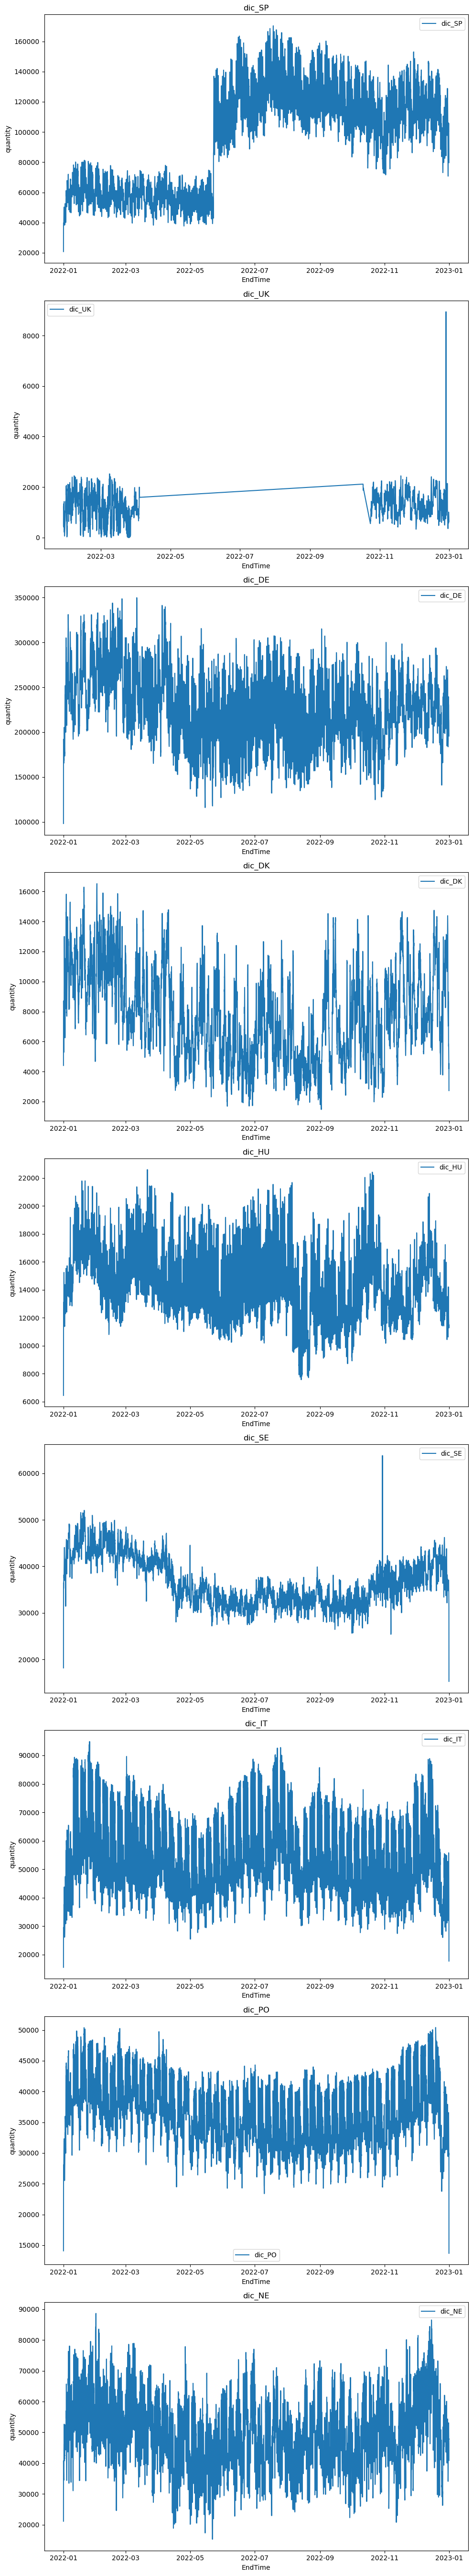

In [273]:
fig, axs = plt.subplots(len(output_1), 1, figsize=(10, 6 * len(output_1)))

# Iterar sobre cada DataFrame en el diccionario
for i, (nombre, df) in enumerate(output_1.items()):
    axs[i].plot(df['EndTime'], df['quantity'], label=nombre)
    axs[i].set_title(nombre)
    axs[i].set_xlabel('EndTime')
    axs[i].set_ylabel('quantity')
    axs[i].legend()

plt.tight_layout()
plt.show()

## FINISH GEN FILES

## WORKING 1..2..3 (LOAD FILES)

In [644]:
import os
import pandas as pd
import re
import json

# Directory where raw CSV files are stored
directory = "../jupyter_notebook/data_samples"
# Parsing date strings, ignoring any timezone information and converting them to datetime objects
date_parser = lambda x: pd.to_datetime(x[:22])
# List to hold all the dataframes
dataframes = []
dict_of_dfs_load = {}

# Iterate through all files in the directory
for filename in os.listdir(directory):

    if re.match(r'load_[A-Z]{2}+\.csv', filename):
        
        # Read the CSV file
        df = pd.read_csv(os.path.join(directory, filename), converters={'EndTime': date_parser}).set_index('EndTime')
        
        _, country = filename.split('_')
        
        country = country.replace('.csv', '') # Remove the file extension
                
        numeric_cols = df.select_dtypes(include=['number'])
        categorical_cols = df.select_dtypes(exclude=['number', 'datetime64[ns]', 'bool'])
        
        # Resample the numeric columns and sum
        resampled_df_num = numeric_cols.resample('H').sum()

        # Resample the categorical columns.
        # Here, we take the first value. Adjust the method if needed (e.g., 'last', or a custom function to get the mode)
        resampled_df_cat= categorical_cols.resample('H').last()
        
        resampled_df = pd.concat([resampled_df_num, resampled_df_cat], axis=1)
        
        dict_of_dfs_load[country]=resampled_df
        

In [638]:
dict_of_dfs_load['dic_SP']

Load                StartTime            AreaID  \
EndTime                                                                        
2022-01-01 00:00:00+00:00   20827  2021-12-31T23:00+00:00Z  10YES-REE------0   
2022-01-01 01:00:00+00:00   19530  2022-01-01T00:00+00:00Z  10YES-REE------0   
2022-01-01 02:00:00+00:00   18383  2022-01-01T01:00+00:00Z  10YES-REE------0   
2022-01-01 03:00:00+00:00   17680  2022-01-01T02:00+00:00Z  10YES-REE------0   
2022-01-01 04:00:00+00:00   17396  2022-01-01T03:00+00:00Z  10YES-REE------0   
...                           ...                      ...               ...   
2022-12-31 19:00:00+00:00  105380  2022-12-31T19:30+00:00Z  10YES-REE------0   
2022-12-31 20:00:00+00:00   99784  2022-12-31T20:30+00:00Z  10YES-REE------0   
2022-12-31 21:00:00+00:00   89176  2022-12-31T21:30+00:00Z  10YES-REE------0   
2022-12-31 22:00:00+00:00   83200  2022-12-31T22:30+00:00Z  10YES-REE------0   
2022-12-31 23:00:00+00:00   79988  2022-12-31T23:30+00:00Z  10YES-REE------0   

                          UnitName  
EndTime                             
2022-01-01 00:00:00+00:00      MAW  
2022-01-01 01:00:00+00:00      MAW  
2022-01-01 02:00:00+00:00      MAW  
2022-01-01 03:00:00+00:00      MAW  
2022-01-01 04:00:00+00:00      MAW  
...                            ...  
2022-12-31 19:00:00+00:00      MAW  
2022-12-31 20:00:00+00:00      MAW  
2022-12-31 21:00:00+00:00      MAW  
2022-12-31 22:00:00+00:00      MAW  
2022-12-31 23:00:00+00:00      MAW  

[8760 rows x 4 columns]

In [634]:
import os
import pandas as pd
import re
import json

# Directory where raw CSV files are stored
directory = "../jupyter_notebook/data_samples"
# Parsing date strings, ignoring any timezone information and converting them to datetime objects
date_parser = lambda x: pd.to_datetime(x[:22])
# List to hold all the dataframes
dataframes = []
dict_of_dfs_load = {}

# Iterate through all files in the directory
for filename in os.listdir(directory):

    if re.match(r'load_[A-Z]{2}+\.csv', filename):
        
        # Read the CSV file
        df = pd.read_csv(os.path.join(directory, filename), converters={'EndTime': date_parser}).set_index('EndTime')
        print(f'{filename}:{len(df)}')
        
        df.dropna(inplace=True)
        print(f'Drop"{filename}:{len(df)}')



load_SP.csv:24816
Drop:load_SP.csv:24816
load_SE.csv:8760
Drop:load_SE.csv:8760
load_DK.csv:8760
Drop:load_DK.csv:8760
load_PO.csv:8760
Drop:load_PO.csv:8760
load_NE.csv:35040
Drop:load_NE.csv:35040
load_UK.csv:9342
Drop:load_UK.csv:9342
load_IT.csv:8760
Drop:load_IT.csv:8760
load_DE.csv:35040
Drop:load_DE.csv:35040
load_HU.csv:35040
Drop:load_HU.csv:35040


In [244]:
dict_of_dfs_load['dic_SP']

Load                StartTime            AreaID  \
EndTime                                                                        
2022-01-01 00:00:00+00:00   20827  2021-12-31T23:00+00:00Z  10YES-REE------0   
2022-01-01 01:00:00+00:00   19530  2022-01-01T00:00+00:00Z  10YES-REE------0   
2022-01-01 02:00:00+00:00   18383  2022-01-01T01:00+00:00Z  10YES-REE------0   
2022-01-01 03:00:00+00:00   17680  2022-01-01T02:00+00:00Z  10YES-REE------0   
2022-01-01 04:00:00+00:00   17396  2022-01-01T03:00+00:00Z  10YES-REE------0   
...                           ...                      ...               ...   
2022-12-31 19:00:00+00:00  105380  2022-12-31T19:30+00:00Z  10YES-REE------0   
2022-12-31 20:00:00+00:00   99784  2022-12-31T20:30+00:00Z  10YES-REE------0   
2022-12-31 21:00:00+00:00   89176  2022-12-31T21:30+00:00Z  10YES-REE------0   
2022-12-31 22:00:00+00:00   83200  2022-12-31T22:30+00:00Z  10YES-REE------0   
2022-12-31 23:00:00+00:00   79988  2022-12-31T23:30+00:00Z  10YES-REE------0   

                          UnitName  
EndTime                             
2022-01-01 00:00:00+00:00      MAW  
2022-01-01 01:00:00+00:00      MAW  
2022-01-01 02:00:00+00:00      MAW  
2022-01-01 03:00:00+00:00      MAW  
2022-01-01 04:00:00+00:00      MAW  
...                            ...  
2022-12-31 19:00:00+00:00      MAW  
2022-12-31 20:00:00+00:00      MAW  
2022-12-31 21:00:00+00:00      MAW  
2022-12-31 22:00:00+00:00      MAW  
2022-12-31 23:00:00+00:00      MAW  

[8760 rows x 4 columns]

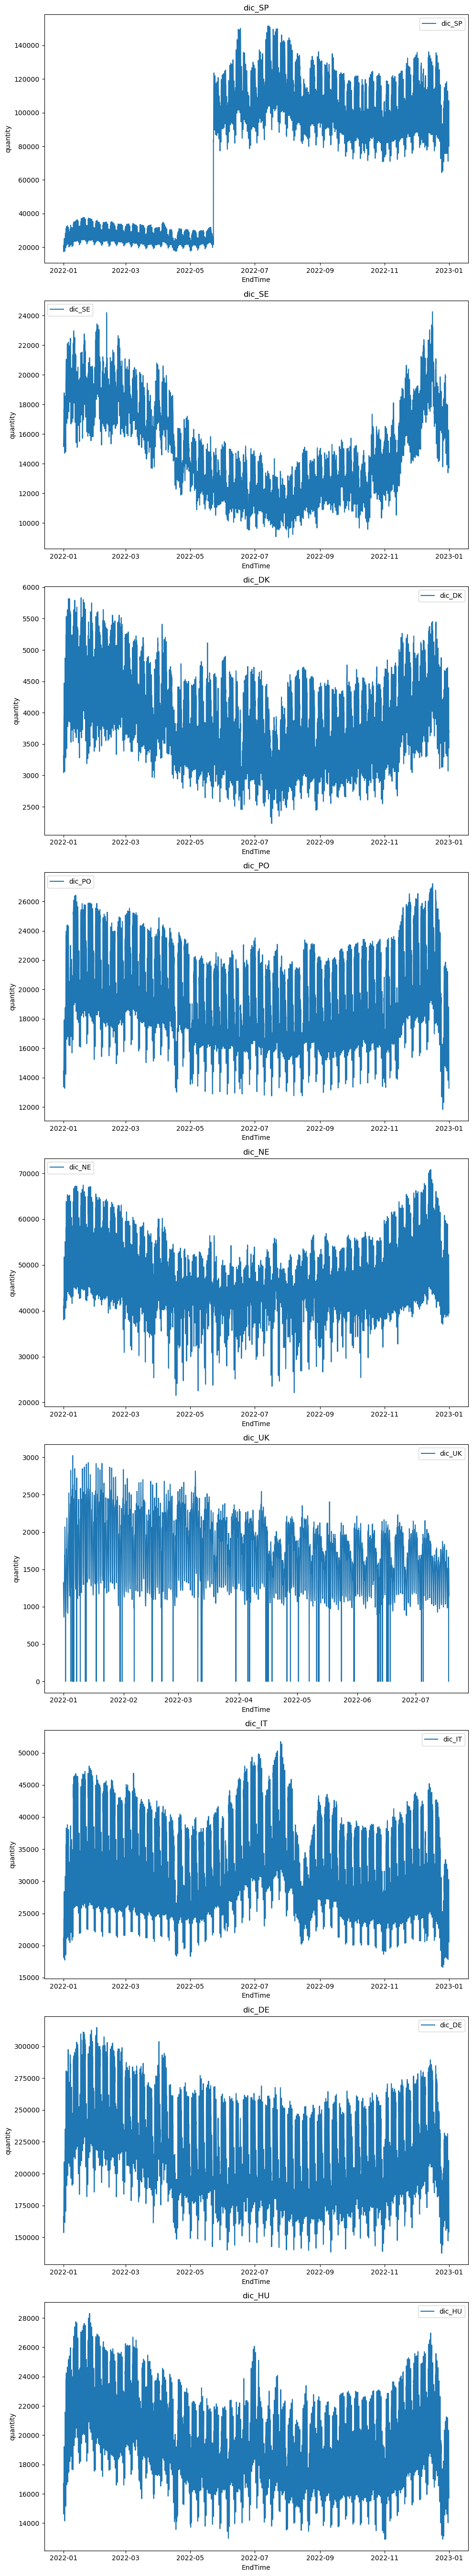

In [245]:
fig, axs = plt.subplots(len(dict_of_dfs_load), 1, figsize=(10, 6 * len(dict_of_dfs_load)))

# Iterar sobre cada DataFrame en el diccionario
for i, (nombre, df) in enumerate(dict_of_dfs_load.items()):
    axs[i].plot(df.index, df['Load'], label=nombre)
    axs[i].set_title(nombre)
    axs[i].set_xlabel('EndTime')
    axs[i].set_ylabel('quantity')
    axs[i].legend()

plt.tight_layout()
plt.show()

## FINISH LOAD FILES

## WORKING 1..2..3 (SURPLUS CALCULATION)

In [246]:
dict_gen=output_1.copy() #Dic Dataframes with gen energy
dict_load=dict_of_dfs_load #Dic Dataframes with load energy

In [247]:
for name,df in dict_load.items():
    dict_load[name]=dict_load[name][['Load']]

In [251]:
dict_gen['dic_SP'][dict_gen['dic_SP']['EndTime']=='2022-01-01 00:00:00+00:00']

EndTime  quantity
0 2022-01-01 00:00:00+00:00         0

In [266]:
# Parsing date strings, ignoring any timezone information and converting them to datetime objects
date_parser = lambda x: pd.to_datetime(x[:22])

df = pd.read_csv("../jupyter_notebook/data_samples/gen_UK_B04.csv", 
                 converters={'EndTime': date_parser, 'StartTime': date_parser})

## OTHER APPROACH

In [ ]:
#35040 (15 min)
#17462 (30 min)
#8760 (1 hora)

In [542]:
import os
import pandas as pd
import re
import json

# Directory where raw CSV files are stored
directory = "../jupyter_notebook/data_samples"
# Parsing date strings, ignoring any timezone information and converting them to datetime objects
date_parser = lambda x: pd.to_datetime(x[:22])
# List to hold all the dataframes
dataframes = []
dict_of_dfs = {}
energy_type_codes_to_filter = ['B01', 'B09', 'B10', 'B11', 'B12', 'B13', 'B15', 'B18', 'B19']


# Iterate through all files in the directory
for filename in os.listdir(directory):
    # Verifica si el nombre del archivo cumple con el patrón deseado
    match = re.match(r'gen_[A-Z]{2}_(\w{3})\.csv', filename)

    if match:
        # Extrae el tipo de energía del grupo capturado en el patrón regex
        energy_type = match.group(1)

        # Verifica si el tipo de energía está en la lista de códigos para filtrar
        if energy_type in energy_type_codes_to_filter:
            
            # Read the CSV file
            df = pd.read_csv(os.path.join(directory, filename), converters={'EndTime': date_parser})

            # Extract country and energy type from filename
            _, country, energy_type = filename.split('_')
            energy_type = energy_type.replace('.csv', '') # Remove the file extension

            # Add country and energy type as new columns
            df['CountryCode'] = country
            df['EnergyTypeCode'] = energy_type

            df.dropna(inplace=True)

            #Tipo de dato a datetime
            df['EndTime'] = pd.to_datetime(df['EndTime'])

            # Calcula la diferencia de tiempo entre filas consecutivas en minutos
            df['TimeDifference'] = df['EndTime'].diff().dt.total_seconds() / 60

            #Guarda la diferencia en un valor para resamplear.
            valor = int(df.loc[(df['TimeDifference'] > 0) & (df['TimeDifference'] <= 60), 'TimeDifference'].values[0])

            #Setea como indice al EndTime.
            df.set_index('EndTime', inplace=True)

            if valor<60:
                valor=str(valor)
                df = df.resample(f'{valor}T').asfreq()

            df['DateHour'] = df.index.floor('H')
            df.reset_index('EndTime', inplace=True)

            grouped_df = df.groupby('DateHour')['quantity'].sum().reset_index()
            grouped_df = grouped_df.rename(columns={'quantity': 'HourlySum'})

            df = pd.merge(df, grouped_df, how='left', left_on='DateHour', right_on='DateHour')

            df=df[~((df['quantity'].isnull())&(df['HourlySum']==0))]

            df.interpolate(method='linear', limit_direction='both', inplace=True)

            df.set_index('EndTime',inplace=True)

            numeric_cols = df.select_dtypes(include=['number'])
            categorical_cols = df.select_dtypes(exclude=['number', 'datetime64[ns]', 'bool'])

            # Resample the numeric columns and sum
            resampled_df_num = numeric_cols.resample('H').sum()

            # Resample the categorical columns.
            # Here, we take the first value. Adjust the method if needed (e.g., 'last', or a custom function to get the mode)
            resampled_df_cat= categorical_cols.resample('H').last()

            resampled_df = pd.concat([resampled_df_num, resampled_df_cat], axis=1)

            resampled_df.dropna(inplace=True)

            # Append the dataframe to the list
            dataframes.append(resampled_df)

            dict_of_dfs[f'{country}_{energy_type}']=resampled_df

            # Concatenate all dataframes (if needed)
            final_df = pd.concat(dataframes)

# Concatenate all dataframes (if needed)
final_df = pd.concat(dataframes)

# From the EDA (no info given)
dataframes_to_drop = ['SP_B10', 'SE_B13']

for dataframe_name in dataframes_to_drop:
    dict_of_dfs.pop(dataframe_name, None)



In [626]:
dic_gen = {}
for name, df in dict_of_dfs.items():
    gen_key = name.split('_')[0]
    if gen_key not in dic_gen:
        dic_gen[gen_key] = {}  # Inicializa un diccionario vacío para esta clave si no existe
    df.rename(columns={'quantity':f'quantity_{name}'},inplace=True)
    dic_gen[gen_key][name] = df[[f'quantity_{name}']]


In [640]:
dic_gen

{'DE': {'DE_B09':                            quantity_DE_B09
  EndTime                                   
  2022-01-01 00:00:00+00:00            104.0
  2022-01-01 01:00:00+00:00            105.0
  2022-01-01 02:00:00+00:00            108.0
  2022-01-01 03:00:00+00:00            108.0
  2022-01-01 04:00:00+00:00            108.0
  ...                                    ...
  2022-12-31 19:00:00+00:00             92.0
  2022-12-31 20:00:00+00:00             92.0
  2022-12-31 21:00:00+00:00             92.0
  2022-12-31 22:00:00+00:00             92.0
  2022-12-31 23:00:00+00:00            106.0
  
  [8760 rows x 1 columns],
  'DE_B18':                            quantity_DE_B18
  EndTime                                   
  2022-01-01 00:00:00+00:00            23101
  2022-01-01 01:00:00+00:00            22192
  2022-01-01 02:00:00+00:00            21531
  2022-01-01 03:00:00+00:00            22346
  2022-01-01 04:00:00+00:00            18125
  ...                                    ...

In [641]:
from functools import reduce

#dataframes_inner = list(dic_gen['UK'].values())
#result_inner = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how='inner'), dataframes_inner)

# Sumar las columnas 'quantity' de cada DataFrame
#result_inner['quantity_sum'] = result_inner.filter(like='quantity').sum(axis=1)


In [642]:
dic_gen_output={}

for name,df in dic_gen.items():
    dataframes_inner = list(dic_gen[name].values())
    result_inner = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how='inner'), dataframes_inner)
    
    result_inner['quantity_sum'] = result_inner.filter(like='quantity').sum(axis=1)
    
    dic_gen_output[name]=result_inner[['quantity_sum']]
                

/var/folders/13/vtwv0p951k11cf7tvhd750jw0000gn/T/ipykernel_6990/2529805268.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_inner['quantity_sum'] = result_inner.filter(like='quantity').sum(axis=1)


In [643]:
dic_gen_output['UK']

quantity_sum
EndTime                                
2022-01-27 00:00:00+00:00        1810.0
2022-01-27 01:00:00+00:00        2138.0
2022-01-27 02:00:00+00:00        1638.0
2022-01-27 03:00:00+00:00         852.0
2022-01-27 04:00:00+00:00        1068.0
...                                 ...
2022-12-31 19:00:00+00:00         838.0
2022-12-31 20:00:00+00:00         822.0
2022-12-31 21:00:00+00:00         778.0
2022-12-31 22:00:00+00:00         576.0
2022-12-31 23:00:00+00:00         374.0

[3161 rows x 1 columns]

In [569]:
dic_gen['DE']['DE_B09']

quantity  TimeDifference  HourlySum  \
EndTime                                                          
2022-01-01 00:00:00+00:00     104.0            60.0      416.0   
2022-01-01 01:00:00+00:00     105.0            60.0      420.0   
2022-01-01 02:00:00+00:00     108.0            60.0      432.0   
2022-01-01 03:00:00+00:00     108.0            60.0      432.0   
2022-01-01 04:00:00+00:00     108.0            60.0      432.0   
...                             ...             ...        ...   
2022-12-31 19:00:00+00:00      92.0            60.0      368.0   
2022-12-31 20:00:00+00:00      92.0            60.0      368.0   
2022-12-31 21:00:00+00:00      92.0            60.0      368.0   
2022-12-31 22:00:00+00:00      92.0            60.0      368.0   
2022-12-31 23:00:00+00:00     106.0            60.0      424.0   

                                         StartTime            AreaID UnitName  \
EndTime                                                                         
2022-01-01 00:00:00+00:00  2022-01-01T00:30+00:00Z  10Y1001A1001A83F      MAW   
2022-01-01 01:00:00+00:00  2022-01-01T01:30+00:00Z  10Y1001A1001A83F      MAW   
2022-01-01 02:00:00+00:00  2022-01-01T02:30+00:00Z  10Y1001A1001A83F      MAW   
2022-01-01 03:00:00+00:00  2022-01-01T03:30+00:00Z  10Y1001A1001A83F      MAW   
2022-01-01 04:00:00+00:00  2022-01-01T04:30+00:00Z  10Y1001A1001A83F      MAW   
...                                            ...               ...      ...   
2022-12-31 19:00:00+00:00  2022-12-31T19:30+00:00Z  10Y1001A1001A83F      MAW   
2022-12-31 20:00:00+00:00  2022-12-31T20:30+00:00Z  10Y1001A1001A83F      MAW   
2022-12-31 21:00:00+00:00  2022-12-31T21:30+00:00Z  10Y1001A1001A83F      MAW   
2022-12-31 22:00:00+00:00  2022-12-31T22:30+00:00Z  10Y1001A1001A83F      MAW   
2022-12-31 23:00:00+00:00  2022-12-31T23:30+00:00Z  10Y1001A1001A83F      MAW   

                          PsrType CountryCode EnergyTypeCode  \
EndTime                                                        
2022-01-01 00:00:00+00:00     B09          DE            B09   
2022-01-01 01:00:00+00:00     B09          DE            B09   
2022-01-01 02:00:00+00:00     B09          DE            B09   
2022-01-01 03:00:00+00:00     B09          DE            B09   
2022-01-01 04:00:00+00:00     B09          DE            B09   
...                           ...         ...            ...   
2022-12-31 19:00:00+00:00     B09          DE            B09   
2022-12-31 20:00:00+00:00     B09          DE            B09   
2022-12-31 21:00:00+00:00     B09          DE            B09   
2022-12-31 22:00:00+00:00     B09          DE            B09   
2022-12-31 23:00:00+00:00     B09          DE            B09   

                                           DateHour  
EndTime                                              
2022-01-01 00:00:00+00:00 2022-01-01 00:00:00+00:00  
2022-01-01 01:00:00+00:00 2022-01-01 01:00:00+00:00  
2022-01-01 02:00:00+00:00 2022-01-01 02:00:00+00:00  
2022-01-01 03:00:00+00:00 2022-01-01 03:00:00+00:00  
2022-01-01 04:00:00+00:00 2022-01-01 04:00:00+00:00  
...                                             ...  
2022-12-31 19:00:00+00:00 2022-12-31 19:00:00+00:00  
2022-12-31 20:00:00+00:00 2022-12-31 20:00:00+00:00  
2022-12-31 21:00:00+00:00 2022-12-31 21:00:00+00:00  
2022-12-31 22:00:00+00:00 2022-12-31 22:00:00+00:00  
2022-12-31 23:00:00+00:00 2022-12-31 23:00:00+00:00  

[8760 rows x 10 columns]

In [550]:
for key, df in dict_of_dfs.items():
    length = len(df)
    print(f'Longitud de DataFrame {key}: {length}')

Longitud de DataFrame DE_B09: 8760
Longitud de DataFrame NE_B18: 8760
Longitud de DataFrame NE_B19: 8760
Longitud de DataFrame DE_B18: 8760
Longitud de DataFrame DE_B19: 8760
Longitud de DataFrame DK_B01: 8758
Longitud de DataFrame HU_B01: 8760
Longitud de DataFrame HU_B15: 8760
Longitud de DataFrame IT_B10: 8216
Longitud de DataFrame IT_B11: 8760
Longitud de DataFrame UK_B19: 3161
Longitud de DataFrame SP_B01: 8760
Longitud de DataFrame SP_B15: 8760
Longitud de DataFrame PO_B19: 8760
Longitud de DataFrame IT_B12: 8760
Longitud de DataFrame SP_B11: 8760
Longitud de DataFrame HU_B12: 8688
Longitud de DataFrame SP_B13: 8760
Longitud de DataFrame IT_B01: 8760
Longitud de DataFrame SE_B12: 8759
Longitud de DataFrame SP_B12: 8760
Longitud de DataFrame HU_B11: 8760
Longitud de DataFrame IT_B19: 8760
Longitud de DataFrame PO_B12: 8760
Longitud de DataFrame IT_B18: 5258
Longitud de DataFrame HU_B09: 8760
Longitud de DataFrame PO_B10: 8760
Longitud de DataFrame PO_B11: 8760
Longitud de DataFram

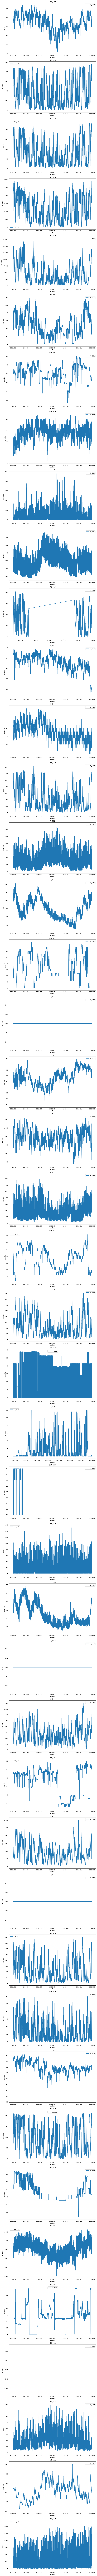

In [551]:
fig, axs = plt.subplots(len(dict_of_dfs), 1, figsize=(10, 6 * len(dict_of_dfs)))

# Iterar sobre cada DataFrame en el diccionario
for i, (nombre, df) in enumerate(dict_of_dfs.items()):
    axs[i].plot(df.index, df['quantity'], label=nombre)
    axs[i].set_title(nombre)
    axs[i].set_xlabel('EndTime')
    axs[i].set_ylabel('quantity')
    axs[i].legend()

plt.tight_layout()
plt.show()

In [480]:
df.dropna(inplace=True)

#Tipo de dato a datetime
df['EndTime'] = pd.to_datetime(df['EndTime'])

# Calcula la diferencia de tiempo entre filas consecutivas en minutos
df['TimeDifference'] = df['EndTime'].diff().dt.total_seconds() / 60

#Guarda la diferencia en un valor para resamplear.
valor = int(df['TimeDifference'][1])

#Setea como indice al EndTime.
df.set_index('EndTime', inplace=True)

if valor<60:
    valor=str(valor)
    df = df.resample(f'{valor}T').asfreq()

df['DateHour'] = df.index.floor('H')
df.reset_index('EndTime', inplace=True)

grouped_df = df.groupby('DateHour')['quantity'].sum().reset_index()
grouped_df = grouped_df.rename(columns={'quantity': 'HourlySum'})

df = pd.merge(df, grouped_df, how='left', left_on='DateHour', right_on='DateHour')

df=df[~((df['quantity'].isnull())&(df['HourlySum']==0))]

df.interpolate(method='linear', limit_direction='both', inplace=True)

df.set_index('EndTime',inplace=True)

numeric_cols = df.select_dtypes(include=['number'])
categorical_cols = df.select_dtypes(exclude=['number', 'datetime64[ns]', 'bool'])

# Resample the numeric columns and sum
resampled_df_num = numeric_cols.resample('H').sum()

# Resample the categorical columns.
# Here, we take the first value. Adjust the method if needed (e.g., 'last', or a custom function to get the mode)
resampled_df_cat= categorical_cols.resample('H').last()

resampled_df = pd.concat([resampled_df_num, resampled_df_cat], axis=1)

resampled_df.dropna(inplace=True)

# Append the dataframe to the list
dataframes.append(resampled_df)

dict_of_dfs[f'{country}_{energy_type}']=resampled_df

# Concatenate all dataframes (if needed)
final_df = pd.concat(dataframes)


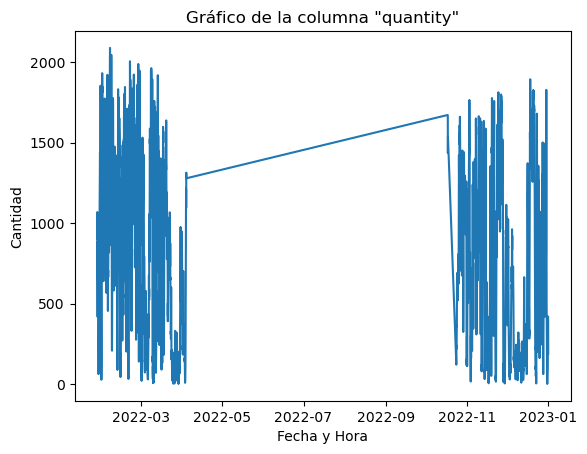

In [486]:

import matplotlib.pyplot as plt

# Suponiendo que ya tienes el DataFrame df con la columna 'quantity'

# Graficar la columna 'quantity'
plt.plot(resampled_df.index, resampled_df['quantity'])

# Añadir etiquetas y título
plt.xlabel('Fecha y Hora')
plt.ylabel('Cantidad')
plt.title('Gráfico de la columna "quantity"')

# Mostrar la leyenda si es necesario
# plt.legend(['quantity'])

# Mostrar el gráfico
plt.show()


EndTime                 StartTime            AreaID  \
0     2022-01-27 00:00:00+00:00 2022-01-26 23:30:00+00:00  10Y1001A1001A92E   
1     2022-01-27 00:30:00+00:00 2022-01-27 00:00:00+00:00  10Y1001A1001A92E   
2     2022-01-27 01:00:00+00:00 2022-01-27 00:30:00+00:00  10Y1001A1001A92E   
3     2022-01-27 01:30:00+00:00 2022-01-27 01:00:00+00:00  10Y1001A1001A92E   
4     2022-01-27 02:00:00+00:00 2022-01-27 01:30:00+00:00  10Y1001A1001A92E   
...                         ...                       ...               ...   
16267 2022-12-31 21:30:00+00:00 2022-12-31 21:00:00+00:00  10Y1001A1001A92E   
16268 2022-12-31 22:00:00+00:00 2022-12-31 21:30:00+00:00  10Y1001A1001A92E   
16269 2022-12-31 22:30:00+00:00 2022-12-31 22:00:00+00:00  10Y1001A1001A92E   
16270 2022-12-31 23:00:00+00:00 2022-12-31 22:30:00+00:00  10Y1001A1001A92E   
16271 2022-12-31 23:30:00+00:00 2022-12-31 23:00:00+00:00  10Y1001A1001A92E   

      UnitName PsrType  quantity  TimeDifference                  DateHour  \
0          MAW     B19     433.0             NaN 2022-01-27 00:00:00+00:00   
1          MAW     B19     472.0            30.0 2022-01-27 00:00:00+00:00   
2          MAW     B19     549.0            30.0 2022-01-27 01:00:00+00:00   
3          MAW     B19     520.0            30.0 2022-01-27 01:00:00+00:00   
4          MAW     B19     407.0            30.0 2022-01-27 02:00:00+00:00   
...        ...     ...       ...             ...                       ...   
16267      MAW     B19     183.0            30.0 2022-12-31 21:00:00+00:00   
16268      MAW     B19     155.0            30.0 2022-12-31 22:00:00+00:00   
16269      MAW     B19     133.0            30.0 2022-12-31 22:00:00+00:00   
16270      MAW     B19     112.0            30.0 2022-12-31 23:00:00+00:00   
16271      MAW     B19      75.0            30.0 2022-12-31 23:00:00+00:00   

       HourlySum  
0          905.0  
1          905.0  
2         1069.0  
3         1069.0  
4          819.0  
...          ...  
16267      389.0  
16268      288.0  
16269      288.0  
16270      187.0  
16271      187.0  

[6322 rows x 9 columns]

In [440]:
df[~((df['HourlySum']==0)&(df['quantity'].isnull()))]

EndTime                 StartTime            AreaID  \
0     2022-01-27 00:00:00+00:00 2022-01-26 23:30:00+00:00  10Y1001A1001A92E   
1     2022-01-27 00:30:00+00:00 2022-01-27 00:00:00+00:00  10Y1001A1001A92E   
2     2022-01-27 01:00:00+00:00 2022-01-27 00:30:00+00:00  10Y1001A1001A92E   
3     2022-01-27 01:30:00+00:00 2022-01-27 01:00:00+00:00  10Y1001A1001A92E   
4     2022-01-27 02:00:00+00:00 2022-01-27 01:30:00+00:00  10Y1001A1001A92E   
...                         ...                       ...               ...   
16267 2022-12-31 21:30:00+00:00 2022-12-31 21:00:00+00:00  10Y1001A1001A92E   
16268 2022-12-31 22:00:00+00:00 2022-12-31 21:30:00+00:00  10Y1001A1001A92E   
16269 2022-12-31 22:30:00+00:00 2022-12-31 22:00:00+00:00  10Y1001A1001A92E   
16270 2022-12-31 23:00:00+00:00 2022-12-31 22:30:00+00:00  10Y1001A1001A92E   
16271 2022-12-31 23:30:00+00:00 2022-12-31 23:00:00+00:00  10Y1001A1001A92E   

      UnitName PsrType  quantity  TimeDifference                  DateHour  \
0          MAW     B19     433.0             NaN 2022-01-27 00:00:00+00:00   
1          MAW     B19     472.0            30.0 2022-01-27 00:00:00+00:00   
2          MAW     B19     549.0            30.0 2022-01-27 01:00:00+00:00   
3          MAW     B19     520.0            30.0 2022-01-27 01:00:00+00:00   
4          MAW     B19     407.0            30.0 2022-01-27 02:00:00+00:00   
...        ...     ...       ...             ...                       ...   
16267      MAW     B19     183.0            30.0 2022-12-31 21:00:00+00:00   
16268      MAW     B19     155.0            30.0 2022-12-31 22:00:00+00:00   
16269      MAW     B19     133.0            30.0 2022-12-31 22:00:00+00:00   
16270      MAW     B19     112.0            30.0 2022-12-31 23:00:00+00:00   
16271      MAW     B19      75.0            30.0 2022-12-31 23:00:00+00:00   

       HourlySum  
0          905.0  
1          905.0  
2         1069.0  
3         1069.0  
4          819.0  
...          ...  
16267      389.0  
16268      288.0  
16269      288.0  
16270      187.0  
16271      187.0  

[6322 rows x 9 columns]

In [ ]:
resampled_df[resampled_df['quantity'].isna()]